In [44]:
import pandas as pd
import numpy as np
import seaborn as sn
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor 

In [45]:
df=pd.read_excel('Data_train.xlsx')
df.head(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


### Cleaning the Data 

In [46]:
df.tail(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648
10682,Air India,9/05/2019,Delhi,Cochin,DEL → GOI → BOM → COK,10:55,19:15,8h 20m,2 stops,No info,11753


In [47]:
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [48]:
df=df.dropna(subset=['Route','Total_Stops'])

In [49]:
df['Additional_Info'].value_counts()

Additional_Info
No info                         8344
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: count, dtype: int64

## Feature Engineering 

In [50]:
df['Day_of_Journey'] = pd.to_datetime(df['Date_of_Journey'],format= "%d/%m/%Y").dt.day
df['Month_of_Journey'] = pd.to_datetime(df['Date_of_Journey'],format= "%d/%m/%Y").dt.month

In [51]:
df['Dep_hour'] = pd.to_datetime(df['Dep_Time']).dt.hour
df['Dep_min'] = pd.to_datetime(df['Dep_Time']).dt.minute

C:\Users\santj\AppData\Local\Temp\ipykernel_10452\3804065798.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Dep_hour'] = pd.to_datetime(df['Dep_Time']).dt.hour
C:\Users\santj\AppData\Local\Temp\ipykernel_10452\3804065798.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Dep_min'] = pd.to_datetime(df['Dep_Time']).dt.minute


In [52]:
df['Arr_hour'] = pd.to_datetime(df['Arrival_Time']).dt.hour
df['Arr_min'] = pd.to_datetime(df['Arrival_Time']).dt.minute

C:\Users\santj\AppData\Local\Temp\ipykernel_10452\1324446684.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Arr_hour'] = pd.to_datetime(df['Arrival_Time']).dt.hour
C:\Users\santj\AppData\Local\Temp\ipykernel_10452\1324446684.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Arr_min'] = pd.to_datetime(df['Arrival_Time']).dt.minute


In [53]:
df = df.drop(['Dep_Time','Arrival_Time','Date_of_Journey'],axis=1)

In [54]:
df.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Day_of_Journey,Month_of_Journey,Dep_hour,Dep_min,Arr_hour,Arr_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,12,5,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,1,3,16,50,21,35


In [55]:
s='19h'
#h=s.split()[0][:-1]
#m=s.split()[1][:-1]
d=s[:-1]
d

'19'

In [56]:
import re

def duration_hours(d):
    hours_match = re.search(r'(\d+)h', d)
    if hours_match:
        return int(hours_match.group(1))
    else:
        return 0

def duration_mins(d):
    mins_match = re.search(r'(\d+)m', d)
    if mins_match:
        return int(mins_match.group(1))
    else:
        return 0

df['Duration_hours'] = df['Duration'].apply(lambda x: duration_hours(x))
df['Duration_mins'] = df['Duration'].apply(lambda x: duration_mins(x))



In [57]:
df.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Day_of_Journey,Month_of_Journey,Dep_hour,Dep_min,Arr_hour,Arr_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,1,3,16,50,21,35,4,45


In [58]:
df['Total_Stops'].unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', '4 stops'],
      dtype=object)

In [59]:
s='0 st'
s[:1]

'0'

In [60]:
def stops(value):
    if('n' in value):
        return 0
    else:
        return int(value[:1])
df['Total_Stops'] = df['Total_Stops'].apply(lambda x : stops(x))

In [61]:
df['Total_Stops'].unique()


array([0, 2, 1, 3, 4], dtype=int64)

### Gaining Insights through Graphs 

In [62]:
df['Airline'].unique()

array(['IndiGo', 'Air India', 'Jet Airways', 'SpiceJet',
       'Multiple carriers', 'GoAir', 'Vistara', 'Air Asia',
       'Vistara Premium economy', 'Jet Airways Business',
       'Multiple carriers Premium economy', 'Trujet'], dtype=object)

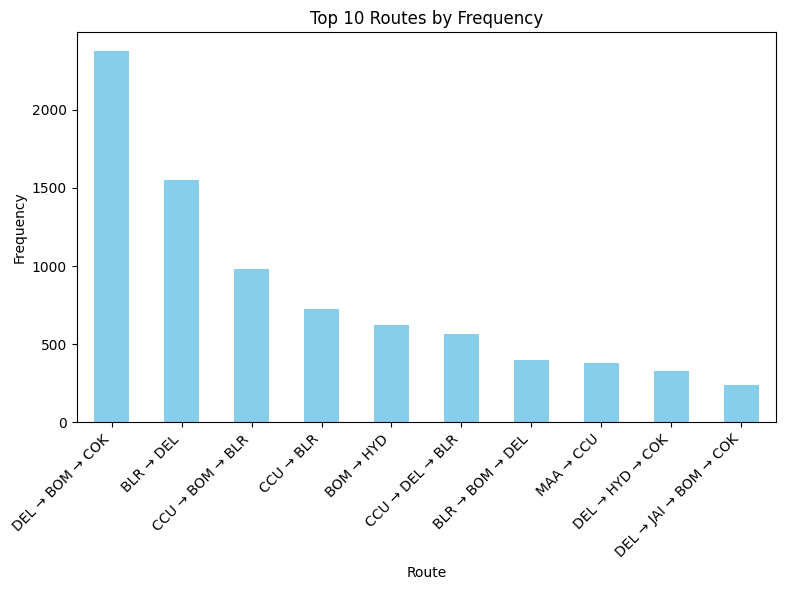

In [63]:
route_frequency = df['Route'].value_counts()

# Extracting top 10 unique routes
top_10_routes = route_frequency.head(10)

# Plotting bar graph
plt.figure(figsize=(8,6))
top_10_routes.plot(kind='bar', color='skyblue')
plt.title('Top 10 Routes by Frequency')
plt.xlabel('Route')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


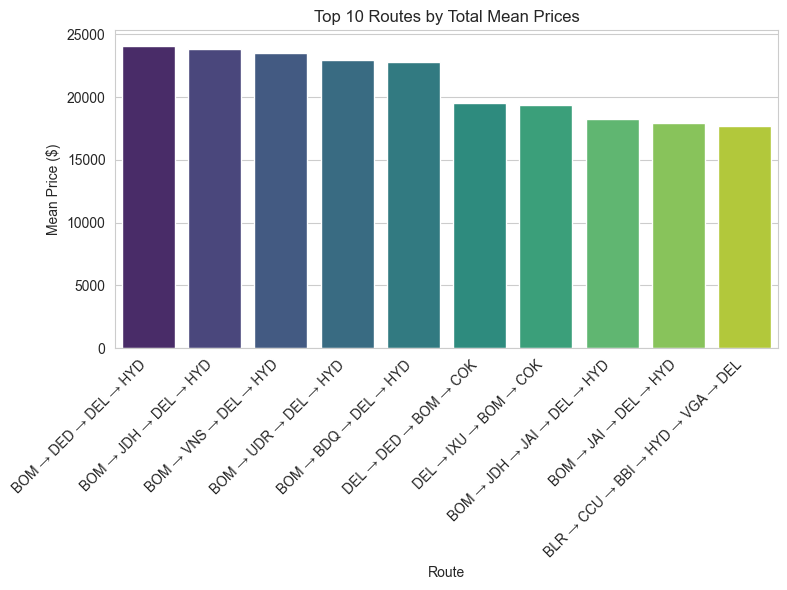

In [64]:
# Assuming df is your DataFrame containing the 'Route' and 'Price' columns
route_mean_prices = df.groupby('Route')['Price'].mean()
top_10_routes = route_mean_prices.nlargest(10).reset_index()

sn.set_style("whitegrid")
plt.figure(figsize=(8,6))
sn.barplot(x='Route', y='Price', data=top_10_routes, palette='viridis')
plt.title('Top 10 Routes by Total Mean Prices')
plt.xlabel('Route')
plt.ylabel('Mean Price ($)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


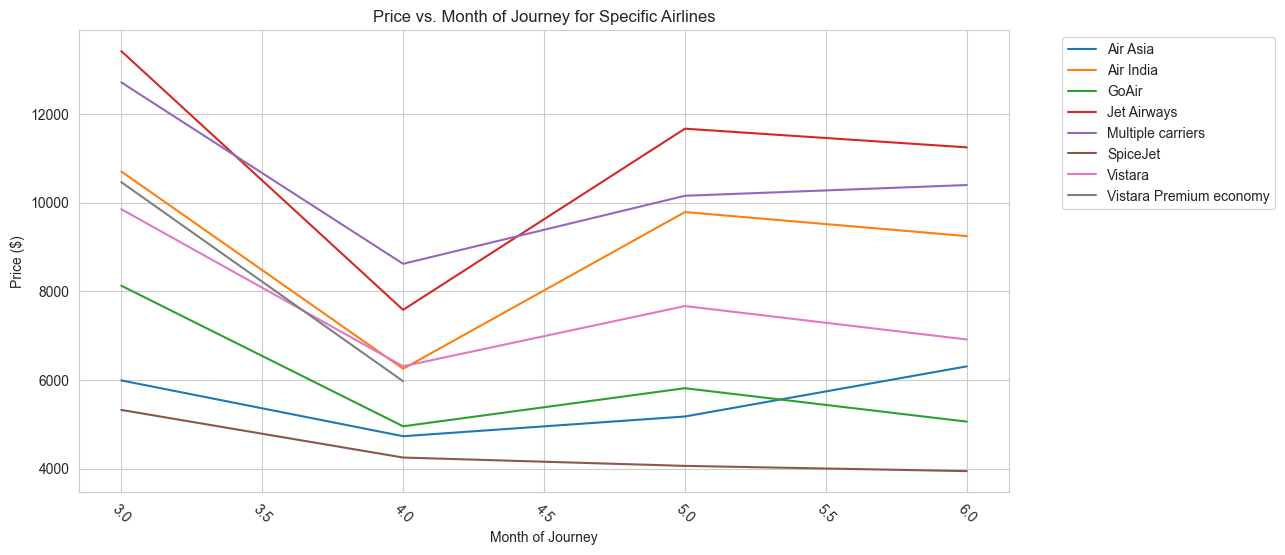

In [65]:
# Filter data for specific airlines
specific_airlines = ['Air India', 'Jet Airways', 'SpiceJet', 'Multiple carriers', 'GoAir', 'Vistara', 'Air Asia', 'Vistara Premium economy']
df_specific = df[df['Airline'].isin(specific_airlines)]

# Calculate average price for each airline in each month
df_avg_price = df_specific.groupby(['Month_of_Journey', 'Airline'])['Price'].mean().reset_index()

# Plot using Seaborn
plt.figure(figsize=(12,6))
sn.lineplot(data=df_avg_price, x='Month_of_Journey', y='Price', hue='Airline', markers=True)
plt.title('Price vs. Month of Journey for Specific Airlines')
plt.xlabel('Month of Journey')
plt.ylabel('Price ($)')
plt.xticks(rotation=-45)  # Rotate x-axis labels for better readability
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


c:\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


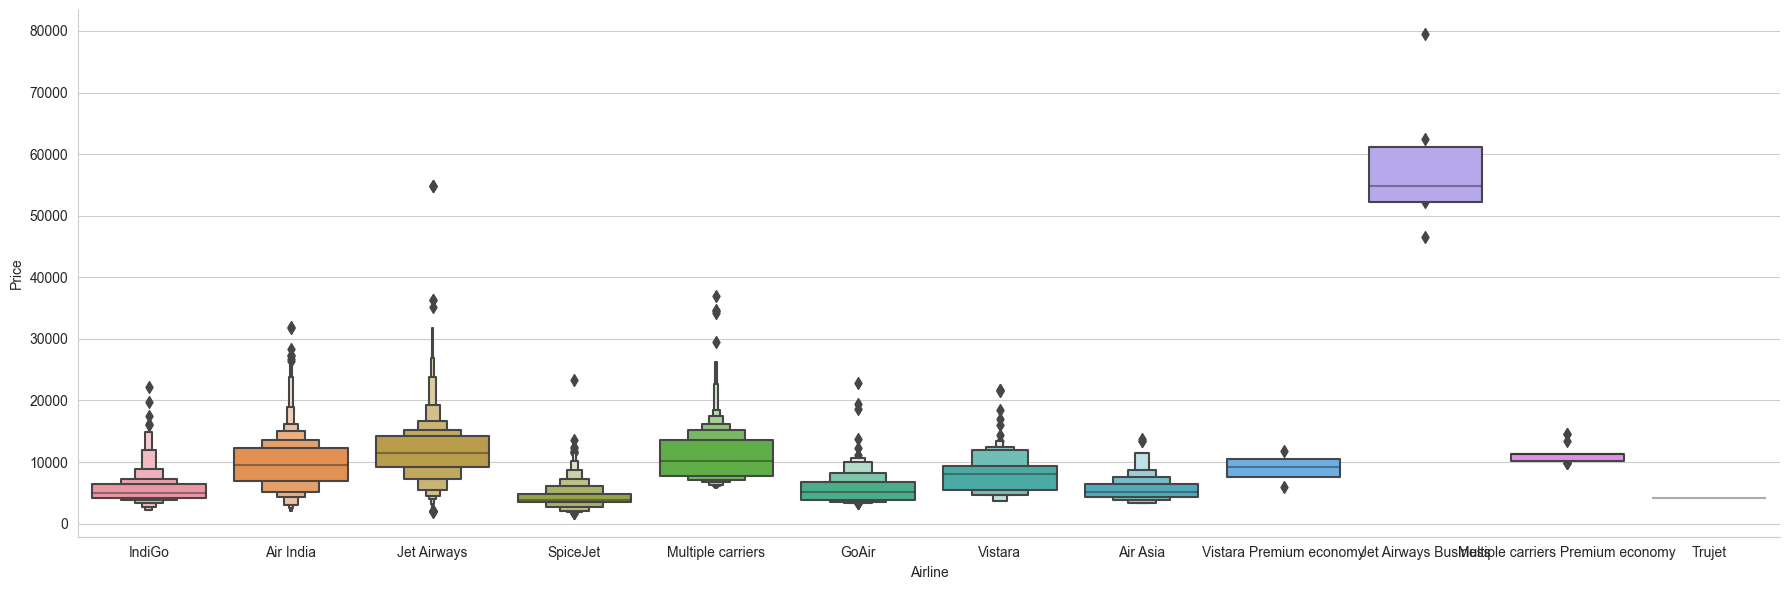

In [66]:
# Airline vs Price
sn.catplot(y = "Price", x = "Airline", data = df, kind="boxen", height = 6, aspect = 3)


c:\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


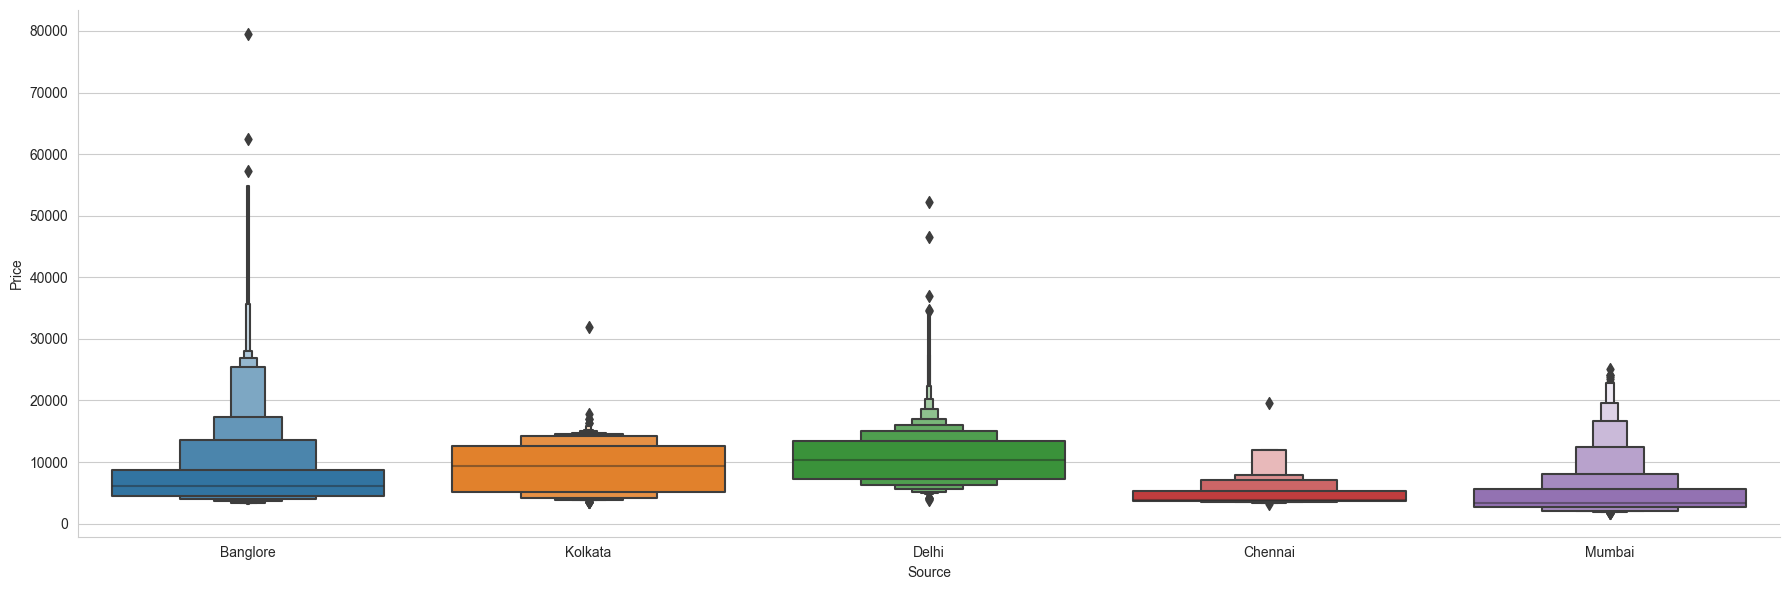

In [67]:
sn.catplot(y = "Price", x = "Source", data = df, kind="boxen", height = 6, aspect = 3)

c:\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


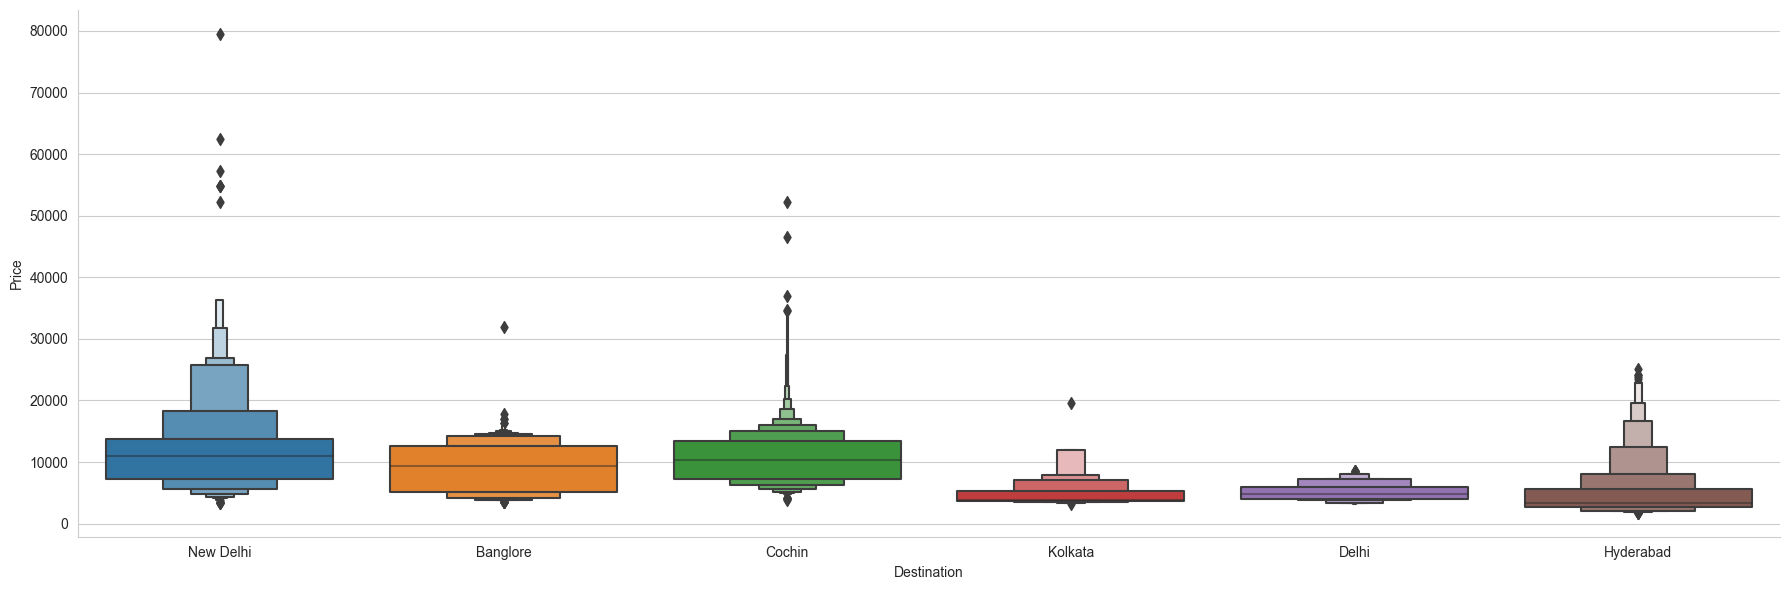

In [68]:
sn.catplot(y = "Price", x = "Destination", data = df, kind="boxen", height = 6, aspect = 3)

In [69]:
df = df.drop(['Route','Additional_Info'],axis=1)

For all the tree coloumns many of them have similar range and the minor differences between them are due to other factors so we will do Nominal Encoding on all the three features so that we'll get a better accuracy

In [70]:
Airline = df[["Airline"]]
Airline = pd.get_dummies(Airline, drop_first= True)

Source = df[["Source"]]
Source = pd.get_dummies(Source, drop_first= True)

Destination = df[["Destination"]]
Destination = pd.get_dummies(Destination, drop_first = True)


In [71]:
df.head()

,Airline,Source,Destination,Duration,Total_Stops,Price,Day_of_Journey,Month_of_Journey,Dep_hour,Dep_min,Arr_hour,Arr_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,2h 50m,0,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,7h 25m,2,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,19h,2,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,5h 25m,1,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,4h 45m,1,13302,1,3,16,50,21,35,4,45


In [72]:
df = pd.concat([df, Airline, Source, Destination], axis = 1)
df = df.drop(['Airline','Source','Destination','Duration'],axis=1)

In [73]:
df.columns

Index(['Total_Stops', 'Price', 'Day_of_Journey', 'Month_of_Journey',
       'Dep_hour', 'Dep_min', 'Arr_hour', 'Arr_min', 'Duration_hours',
       'Duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi'],
      dtype='object')

In [74]:
df.head()

,Total_Stops,Price,Day_of_Journey,Month_of_Journey,Dep_hour,Dep_min,Arr_hour,Arr_min,Duration_hours,Duration_mins,...,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,3897,24,3,22,20,1,10,2,50,...,False,False,False,False,False,False,False,False,False,True
1,2,7662,1,5,5,50,13,15,7,25,...,False,False,False,True,False,False,False,False,False,False
2,2,13882,9,6,9,25,4,25,19,0,...,False,False,True,False,False,True,False,False,False,False
3,1,6218,12,5,18,5,23,30,5,25,...,False,False,False,True,False,False,False,False,False,False
4,1,13302,1,3,16,50,21,35,4,45,...,False,False,False,False,False,False,False,False,False,True


In [75]:
from sklearn.model_selection import train_test_split
X = df.drop(['Price'],axis=1)
y = df[['Price']]
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size = 0.2, random_state = 42)

In [76]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [77]:
df.shape

(10682, 30)

In [78]:
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor()
reg_rf.fit(X_train_s, y_train)

c:\Python311\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor()

In [79]:
y_pred = reg_rf.predict(X_test_s)
metrics.r2_score(y_test, y_pred)

0.7975823971553124

In [80]:
""""param_grid = {'n_estimators':np.arange(100,600,30),
               'max_features': ['auto', 'sqrt'],
               'max_depth': np.arange(5,30,6),
               'min_samples_split': [2, 5, 10, 15, 100],
               'min_samples_leaf': [1, 2, 5, 10]}"""

'"param_grid = {\'n_estimators\':np.arange(100,600,30),\n               \'max_features\': [\'auto\', \'sqrt\'],\n               \'max_depth\': np.arange(5,30,6),\n               \'min_samples_split\': [2, 5, 10, 15, 100],\n               \'min_samples_leaf\': [1, 2, 5, 10]}'

In [81]:
"""rf_random = RandomizedSearchCV(reg_rf, param_grid,cv=5,scoring='neg_mean_squared_error')"""
"""rf_random.fit(X_train,y_train)"""
"""rf_random.best_params_
y_pred = rf_random.predict(X_test)

metrics.r2_score(y_test, y_pred)"""
"""rf_random.best_params_"""

'rf_random.best_params_'

In [82]:
{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 17}

 # These parametersgave us an accuracy above 83

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 17}

In [83]:

reg_rf = RandomForestRegressor(n_estimators= 100,
 min_samples_split=5,
 min_samples_leaf= 1,
 max_features= 'sqrt',
 max_depth= 17)
reg_rf.fit(X_train_s, y_train)
y_pred = reg_rf.predict(X_test_s)

metrics.r2_score(y_test, y_pred)

c:\Python311\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.8316160521932188

In [84]:
import pickle
# open a file, where you want to store the data
file = open('flight_rf.pkl', 'wb')

# dump information to that file
pickle.dump(reg_rf, file)
model = open('flight_rf.pkl','rb')
forest = pickle.load(model)